#  Importing data


In [3]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

fullset = getDF('D:\Download\AMAZON_FASHION_1.json.gz')

In [4]:
# Packages
from time import time
import re
import os
import nltk
import numpy as np
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import pickle
import string

from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from emoji import demojize
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import wordnet


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn import naive_bayes, svm, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve

In [5]:
# Settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
#tqdm.pandas(desc="Progress bar")
Tokenizer = TweetTokenizer()
cores = mp.cpu_count()

import warnings
warnings.filterwarnings('ignore')

In [6]:
def _apply_df(args):
    df, func, kwargs = args
    return df.progress_apply(func, **kwargs)

def multi_apply(df, func, **kwargs):
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))

In [7]:
fullset['polarity'] = fullset.overall.apply(lambda x: 1 if x>= 3.0 else -1)

In [8]:
# Merge title and content
fullset['Text'] = fullset['reviewText']+' '+fullset['summary']
fullset = fullset.drop(columns=['reviewText','summary'])

In [9]:
fullset.to_csv('fullset.csv')
fullset = pd.read_csv('fullset.csv',usecols=['Text','reviewerID','polarity'])

In [10]:
fullset.tail()


,reviewerID,polarity,Text
883631,A1ZSB2Q144UTEY,1,I absolutely love this dress!! It's sexy and ...
883632,A2CCDV0J5VB6F2,1,I'm 5'6 175lbs. I'm on the tall side. I wear a...
883633,A3O90PACS7B61K,1,Too big in the chest area! Three Stars
883634,A2HO94I89U3LNH,1,"Too clear in the back, needs lining Three Stars"
883635,A2RSX9E79DUHRX,1,Ordered and was slightly small. Worked with th...


# Data Preprocessing

In [11]:
# fullset=fullset[~fullset['polarity'].isin(['neutral'])]

In [12]:
fullset['polarity'].value_counts()

 1    711838
-1    171798
Name: polarity, dtype: int64

In [13]:
#Lower case

fullset['Text'] = fullset['Text'].apply(str)
fullset['Text'] = fullset['Text'].apply(lambda x :x.lower())
fullset['Text'] = fullset['Text'].apply(lambda x :re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [14]:
# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return None

In [15]:
fullset['tokens'] = fullset.Text.apply(lambda x: word_tokenize(x))#Tokenization
# fullset['tagged_sent'] = fullset.tokens.apply(lambda x:pos_tag(x))#pos_tag 词性获取

In [16]:
#Lemmatization
wnl = WordNetLemmatizer()
def lem(token):
    return [wnl.lemmatize(x) for x in token]

fullset.tokens = fullset.tokens.apply(lem)

In [17]:
# Negative sentence length
(fullset[fullset.polarity==-1]['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    171798.0
mean        169.0
std         179.0
min           1.0
50%         120.0
95%         481.0
99%         843.0
max        4543.0
Name: Text, dtype: float64

In [18]:
# Positive sentence length
(fullset[fullset.polarity== 1]['Text'].apply(len)).describe(percentiles=[.95, .99]).round(0)

count    711838.0
mean        164.0
std         208.0
min           1.0
50%         100.0
95%         506.0
99%        1010.0
max       10490.0
Name: Text, dtype: float64

In [19]:
stopwordls = stopwords.words('english')

In [20]:
def rmstopword(token):
    return [x for x in token if x not in stopwordls]

In [21]:
# Remove stopwords
fullset.tokens = fullset.tokens.apply(rmstopword)

In [22]:
fullset.tail()

,reviewerID,polarity,Text,tokens
883631,A1ZSB2Q144UTEY,1,i absolutely love this dress its sexy and com...,"[absolutely, love, dress, sexy, comfortable, s..."
883632,A2CCDV0J5VB6F2,1,im 56 175lbs im on the tall side i wear a larg...,"[im, 56, 175lbs, im, tall, side, wear, large, ..."
883633,A3O90PACS7B61K,1,too big in the chest area three stars,"[big, chest, area, three, star]"
883634,A2HO94I89U3LNH,1,too clear in the back needs lining three stars,"[clear, back, need, lining, three, star]"
883635,A2RSX9E79DUHRX,1,ordered and was slightly small worked with the...,"[ordered, wa, slightly, small, worked, company..."


In [23]:
fdist = nltk.FreqDist()

for i in fullset['tokens']:
    for word in i:
        fdist[word] += 1


In [24]:
fdist.most_common(20)

[('star', 325417),
 ('wa', 276164),
 ('fit', 248222),
 ('love', 230657),
 ('great', 225236),
 ('like', 181609),
 ('five', 178088),
 ('size', 177490),
 ('one', 138303),
 ('look', 137459),
 ('good', 136434),
 ('small', 135868),
 ('nice', 128968),
 ('wear', 112979),
 ('quality', 112281),
 ('would', 105355),
 ('cute', 100823),
 ('well', 92573),
 ('perfect', 90435),
 ('little', 87510)]

In [25]:
# How many UNIQUE words
len(fdist)

142324

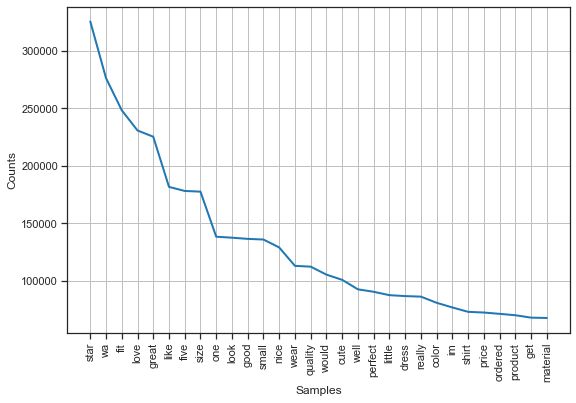

In [26]:
fdist.plot(30)

In [27]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'wb') as f:
    pickle.dump(fullset, f, -1)

# Feature Engineering

In [28]:
with open('fullset_resplit_rmonce_nostopword.pickle', 'rb') as f:
    fullset = pickle.load(f)

In [29]:
fullset.tokens = fullset.tokens.astype('str')

In [30]:
fullset=fullset[['tokens','polarity']]
fullset


,tokens,polarity
0,"['exactly', 'needed', 'perfect', 'replacement']",1
1,"['agree', 'review', 'opening', 'small', 'almos...",-1
2,"['love', 'going', 'order', 'another', 'pack', ...",1
3,"['tiny', 'opening', 'two', 'star']",-1
4,"['okay', 'three', 'star']",1
...,...,...
883631,"['absolutely', 'love', 'dress', 'sexy', 'comfo...",1
883632,"['im', '56', '175lbs', 'im', 'tall', 'side', '...",1
883633,"['big', 'chest', 'area', 'three', 'star']",1
883634,"['clear', 'back', 'need', 'lining', 'three', '...",1


In [31]:
train_x, test_x, train_y, test_y = train_test_split(fullset['tokens'], fullset['polarity'], train_size=0.8, random_state=1, stratify=fullset.polarity
                                                   )


In [32]:
print(train_y)

54392     1
752425    1
45742     1
195061    1
330645    1
         ..
10938    -1
851797    1
35809     1
390426    1
632060    1
Name: polarity, Length: 706908, dtype: int64


# Feature Selection

In [33]:
# The number of unique tokens is 1226
n_features = range(200, 1226+1, 200) # the first model has 200 feature, then 400, 600, etc
cv_errors = []

for p in n_features:
    t0 = time()

    count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=p)
    count_vect_1n.fit(train_x)
    xtrain_count_1n = count_vect_1n.transform(train_x)
    scores = cross_val_score(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, cv=5, scoring = 'accuracy') # 5-fold CV
    err = 1-np.mean(scores)
    cv_errors.append(err.copy())
    print('No. of features:',p,'\nCV_Errors:',err,'\nTime Spent:',time()-t0,'s\n')

No. of features: 200 
CV_Errors: 0.1001926695633445 
Time Spent: 89.40391659736633 s

No. of features: 400 
CV_Errors: 0.08921528668784295 
Time Spent: 86.35339546203613 s

No. of features: 600 
CV_Errors: 0.0856773444294644 
Time Spent: 87.92793321609497 s

No. of features: 800 
CV_Errors: 0.08481018635267235 
Time Spent: 88.046546459198 s

No. of features: 1000 
CV_Errors: 0.08338567324568957 
Time Spent: 86.06484508514404 s

No. of features: 1200 
CV_Errors: 0.08233886060045137 
Time Spent: 87.86525392532349 s



In [34]:
print(cv_errors)

[0.1001926695633445, 0.08921528668784295, 0.0856773444294644, 0.08481018635267235, 0.08338567324568957, 0.08233886060045137]


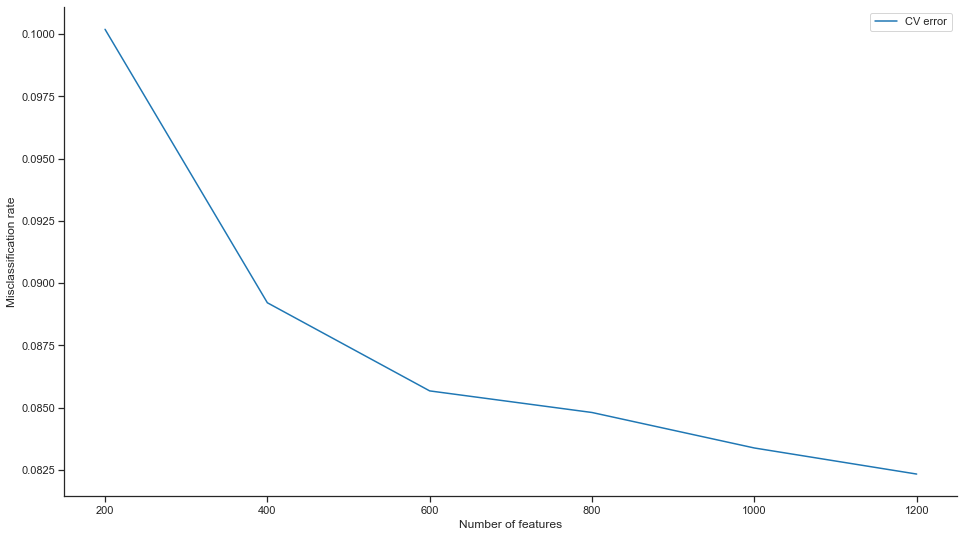

Lowest CV error: K = 1200


In [35]:
fig, ax= plt.subplots(figsize=(16,9))
ax.plot(n_features, cv_errors, label='CV error')
ax.set_xlabel('Number of features')
ax.set_ylabel('Misclassification rate')
plt.legend()
sns.despine()
plt.show()
print('Lowest CV error: K = {}'.format(n_features[np.argmin(cv_errors)]))

In [36]:
errors_op = pd.DataFrame()
errors_op['The Number of features'] = list(n_features)
errors_op['5-fold CV errors'] = cv_errors
errors_op.to_csv('./[ML]cv_errors.csv',index=0)

In [37]:
train_x.tail()

10938     ['son', '2', 'year', 'old', 'bought', 'size', ...
851797    ['daughter', 'love', 'shoe', 'got', 'little', ...
35809     ['excelente', 'producto', 'lo', 'recibi', 'tie...
390426    ['beautiful', 'dress', 'fit', 'perfectly', 'fi...
632060    ['cute', 'design', 'pattern', 'run', 'small', ...
Name: tokens, dtype: object

# Count Vectors + N-gram

In [38]:
t0 = time()
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=1000)
count_vect_3n.fit(fullset['tokens'])
print('# CV + 3-gram:', time()-t0)

# CV + 3-gram: 69.28290224075317


In [39]:
# Transform the training and testing data using count vectorizer object
t0 = time()
xtrain_count_3n = count_vect_3n.transform(train_x)
xvalid_count_3n = count_vect_3n.transform(test_x)
print('# Finish CV 3n:', time()-t0)

# Finish CV 3n: 39.47945594787598


In [40]:
xtrain_count_3n

<706908x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 9188316 stored elements in Compressed Sparse Row format>

In [41]:
xvalid_count_3n

<176728x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 2293912 stored elements in Compressed Sparse Row format>

In [42]:

print(xtrain_count_3n[0])

  (0, 279)	1
  (0, 323)	1
  (0, 341)	1
  (0, 344)	1
  (0, 351)	1
  (0, 493)	1
  (0, 558)	1
  (0, 651)	1
  (0, 673)	1
  (0, 680)	1
  (0, 826)	1
  (0, 912)	1
  (0, 923)	1


# TF-IDF Vectors + N-gram

In [43]:
t0 = time()
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(1,3), token_pattern=r'\w{1,}', max_features=1000)
tfidf_vect_3n.fit(fullset['tokens'])
print('# TF-IDF + 3-gram:', time()-t0)

# TF-IDF + 3-gram: 65.2883608341217


In [44]:
t0 = time()
xtrain_tfidf_3n = tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n = tfidf_vect_3n.transform(test_x)
print('# Finish TF-IDF 3n:', time()-t0)

# Finish TF-IDF 3n: 41.445258378982544


In [45]:
xtrain_tfidf_3n

<706908x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 9188316 stored elements in Compressed Sparse Row format>

In [46]:
xvalid_tfidf_3n

<176728x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 2293912 stored elements in Compressed Sparse Row format>

In [47]:
print(xtrain_tfidf_3n[0])

  (0, 923)	0.3435299954039766
  (0, 912)	0.153899475852404
  (0, 826)	0.2964218727851381
  (0, 680)	0.4021352955680074
  (0, 673)	0.19277241993322516
  (0, 651)	0.2149602886741565
  (0, 558)	0.18609817464266734
  (0, 493)	0.25720218055367144
  (0, 351)	0.2770695442766134
  (0, 344)	0.18302042450851252
  (0, 341)	0.2663928055114344
  (0, 323)	0.38072331415339977
  (0, 279)	0.31367079905733936


In [48]:
print(test_x)

239403                             ['cute', 'five', 'star']
534290    ['three', 'watch', 'bought', 'one', 'came', 'e...
546291    ['niceheavier', 'expected', 'nice', 'heavier',...
622619    ['great', 'purse', 'strap', 'bit', 'thin', 'wo...
816582    ['perfect', 'pam', 'poovey', 'costume', 'five'...
                                ...                        
836446    ['expected', 'full', 'rear', 'coverage', 'cont...
621061                           ['nice', 'jacket', 'nice']
88570     ['cant', 'think', 'anything', 'else', 'say', '...
262087    ['color', 'true', 'copper', 'tone', 'fit', 'pe...
794926    ['decent', 'quality', 'shirt', 'fading', 'shri...
Name: tokens, Length: 176728, dtype: object


# ML-Count Vetors


In [49]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_not_svm=True):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    
    # Here is wrong, the predictions and real label are reversed.
    # In the dissertation, the results are corrected.
    print(confusion_matrix(predictions,test_y))
    print('Accuracy:', accuracy_score(predictions, test_y).round(4))
    print('Precision:', precision_score(predictions, test_y).round(4))
    print('Recall:', recall_score(predictions, test_y).round(4))
    print('F1 Score:', f1_score(predictions, test_y).round(4))

    
    
    if is_not_svm:
        prob = trm.predict_proba(feature_vector_valid)
        fpr, tpr, _ = roc_curve(test_y, prob[:,1])
        auc = roc_auc_score(test_y, prob[:,1])

        fig, ax= plt.subplots(figsize=(8,6))
        ax.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(auc))
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC curve', fontsize=14)
        sns.despine()
        plt.legend()
        plt.show()

[[ 29045   9477]
 [  5315 132891]]
Accuracy: 0.9163
Precision: 0.9334
Recall: 0.9615
F1 Score: 0.9473


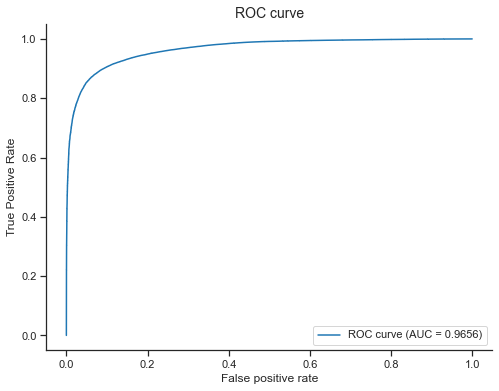

# Naive Bayes + Count Vectors + 3-gram 1.5698320865631104 



In [50]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)
print("# Naive Bayes + Count Vectors + 3-gram", time()-t0, '\n')

[[ 26740   3939]
 [  7620 138429]]
Accuracy: 0.9346
Precision: 0.9723
Recall: 0.9478
F1 Score: 0.9599


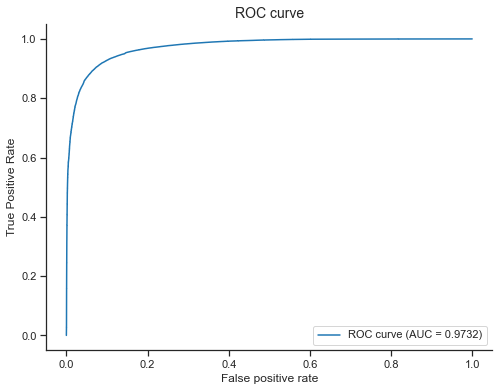


Logistic Regression + Count Vectors + 3-gram 11.194096565246582 



In [51]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)
print("\nLogistic Regression + Count Vectors + 3-gram", time()-t0, '\n')

In [52]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_count_3n, train_y, xvalid_count_3n, is_not_svm=False)
print("# SVM + Count Vectors + 3-gram", time()-t0, '\n')

[[ 26279   3649]
 [  8081 138719]]
Accuracy: 0.9336
Precision: 0.9744
Recall: 0.945
F1 Score: 0.9594
# SVM + Count Vectors + 3-gram 121.6057755947113 



# ML-TF-IDF

[[ 29045   9477]
 [  5315 132891]]
Accuracy: 0.9163
Precision: 0.9334
Recall: 0.9615
F1 Score: 0.9473


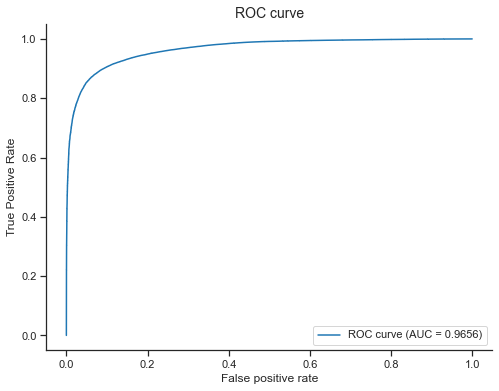

# Naive Bayes + TF-IDF + 3-gram 1.0561997890472412 



In [53]:
t0 = time()
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("# Naive Bayes + TF-IDF + 3-gram", time()-t0, '\n')

[[ 27145   4009]
 [  7215 138359]]
Accuracy: 0.9365
Precision: 0.9718
Recall: 0.9504
F1 Score: 0.961


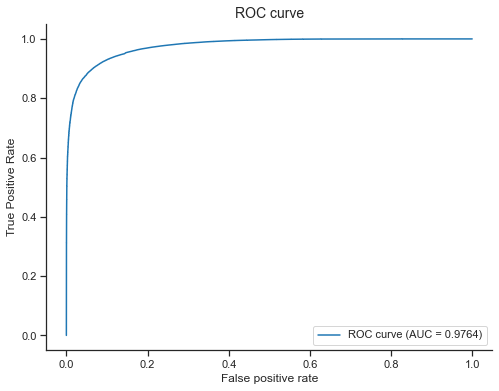


Logistic Regression + TF-IDF + 3-gram 10.62374496459961 



In [54]:
t0 = time()
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)
print("\nLogistic Regression + TF-IDF + 3-gram", time()-t0, '\n')

In [55]:
t0 = time()
train_model(svm.LinearSVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n, is_not_svm=False)
print("# SVM + TF-IDF + 3-gram", time()-t0, '\n')

[[ 27019   3880]
 [  7341 138488]]
Accuracy: 0.9365
Precision: 0.9727
Recall: 0.9497
F1 Score: 0.9611
# SVM + TF-IDF + 3-gram 6.722994565963745 

